<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


# Thorax rotation

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt

# from pyosim import Conf
from pyomeca import Markers3d, Analogs3d, FrameDependentNpArray
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("data_server")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
def parse_conditions(d):
    d["hand"] = d["filename"].str[17]
    d["filename"] = d["filename"].str.replace("wu_expertsnovices[D|G]_", "")
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
        n_trial=lambda x: x["filename"].str.split("_").str[-1],
    )

In [4]:
project_path = Path("/home/romain/Downloads/experts-novices/opensim/")

In [5]:
def correct_path(x):
    return Path(
        x.replace(
            "home/laboratoire/mnt/E/Projet_ExpertsNovices/",
            "/home/romain/Downloads/experts-novices/",
        )
    )

In [6]:
mot = []
f = []
onsets = pd.read_csv(project_path / "onsets.csv")

for _, ifile in onsets.iterrows():
    filename = correct_path(ifile["filepathK"])
    if filename in f:
        continue
    else:
        f.append(filename)

    try:
        e = Analogs3d.from_mot(filename)
    except FileNotFoundError:
        print(f"{filename} not found")
        continue

    idx = np.logical_and(
        e.get_time_frames < ifile["offset"], e.get_time_frames > ifile["onset"]
    )

    e = e[..., idx]

    mot.append(
        e.center()
        .time_normalization()
        .to_dataframe()[["thorax_rotation"]]
        .assign(filename=filename.stem, participant=filename.parent.parent.stem)
    )

/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_1.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_2.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_3.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_4.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_5.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r08_6.mot not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r12_1.mot  not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r12_2.mot  not found
/home/romain/Downloads/experts-novices/opensim/gaud/1_inverse_kinematic/wu_expertsnovicesG_1_r

In [7]:
data = (
    pd.concat(mot)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .pipe(parse_conditions)
    .query('fatigue == 0 & height == "r"')
    .drop("fatigue", axis=1)
)

data.sample(5)

,index,thorax_rotation,filename,participant,hand,expert,height,mass,n_trial
18811,0.25,-70.928271,fras_1_r12_4,fras,D,1,r,12,4
788,0.81,41.978291,antc_1_r08_3,antc,G,0,r,8,3
6194,0.33,-62.890484,blam_1_r12_4,blam,D,1,r,12,4
16671,0.06,-69.883466,erib_1_r12_6,erib,D,1,r,12,6
29643,0.50,54.171624,jull_1_r08_5,jull,D,0,r,8,5


## Correct for left handed

In [8]:
data.loc[data["hand"] == "G", "thorax_rotation"] = (
    data.loc[data["hand"] == "G", "thorax_rotation"] * -1
)

## Correct rotation

In [10]:
data["thorax_rotation"] = data.groupby("filename")["thorax_rotation"].apply(
    lambda x: (x if x.iloc[0] < 0 else -x) + 100
)
# data["thorax_rotation"] = data.groupby("filename")["thorax_rotation"].apply(
#     lambda x: x - x.iloc[0]
# )
# data["thorax_rotation"] = data["thorax_rotation"].replace(to_replace=0, method="bfill")

In [11]:
alt.Chart(data).mark_line(opacity=0.1).encode(
    alt.X("index"),
    alt.Y("thorax_rotation"),
    alt.Detail("filename"),
    alt.Color("expert:N"),
)

alt.Chart(...)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [12]:
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       71
        12      79
1       8       50
        12      39
dtype: int64

In [13]:
balanced_trials = random_balanced_design(
    data, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [14]:
data = data.query("filename == @_filename & participant == @_participant")
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

### Stats

In [15]:
id_vars = ["filename", "participant", "expert", "height", "mass", "n_trial", "index"]
value = "thorax_rotation"
stats_df = (
    data[id_vars]
    .assign(value=data[value])
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
stats_df = stats_df.fillna(stats_df.mean())
stats_df

value             \
index                                                     0.00       0.01   
filename     participant expert height mass n_trial                         
antc_1_r08_1 1           0      r      8    1        -3.980392  -1.019482   
antc_1_r08_4 1           0      r      8    4         0.660772   3.917740   
antc_1_r08_5 1           0      r      8    5        11.631498  14.936522   
antc_1_r08_6 1           0      r      8    6        38.377636  39.114497   
antc_1_r12_1 1           0      r      12   1        20.044923  21.448610   
...                                                        ...        ...   
stec_1_r12_3 25          1      r      12   3        11.449584  14.376635   
stec_1_r12_5 25          1      r      12   5        10.623462  12.048270   
sylg_1_r08_6 26          0      r      8    6        10.567216  13.075154   
sylg_1_r12_1 26          0      r      12   1        -7.952674  -9.474865   
sylg_1_r12_6 26          0      r      12   6        -7.406257  -5.241236   

                                                                           \
index                                                     0.02       0.03   
filename     participant expert height mass n_trial                         
antc_1_r08_1 1           0      r      8    1         1.902022   4.961419   
antc_1_r08_4 1           0      r      8    4         6.862069   9.350654   
antc_1_r08_5 1           0      r      8    5        18.477779  21.760076   
antc_1_r08_6 1           0      r      8    6        39.829056  40.733684   
antc_1_r12_1 1           0      r      12   1        23.403977  24.737253   
...                                                        ...        ...   
stec_1_r12_3 25          1      r      12   3        16.669715  17.988872   
stec_1_r12_5 25          1      r      12   5        13.179278  13.968790   
sylg_1_r08_6 26          0      r      8    6        15.370753  18.193325   
sylg_1_r12_1 26          0      r      12   1        -8.575771  -8.180665   
sylg_1_r12_6 26          0      r      12   6        -3.017300  -0.998312   

                                                                           \
index                                                     0.04       0.05   
filename     participant expert height mass n_trial                         
antc_1_r08_1 1           0      r      8    1         8.064910  10.657947   
antc_1_r08_4 1           0      r      8    4        11.720433  12.766682   
antc_1_r08_5 1           0      r      8    5        23.684276  25.213194   
antc_1_r08_6 1           0      r      8    6        41.578775  42.019953   
antc_1_r12_1 1           0      r      12   1        27.549963  30.026164   
...                                                        ...        ...   
stec_1_r12_3 25          1      r      12   3        19.679090  21.446046   
stec_1_r12_5 25          1      r      12   5        14.440731  15.112324   
sylg_1_r08_6 26          0      r      8    6        19.585010  21.299986   
sylg_1_r12_1 26          0      r      12   1        -9.432919  -8.283528   
sylg_1_r12_6 26          0      r      12   6         1.311576   1.972975   

                                                                           \
index                                                     0.06       0.07   
filename     participant expert height mass n_trial                         
antc_1_r08_1 1           0      r      8    1        12.905089  14.965155   
antc_1_r08_4 1           0      r      8    4        14.504050  16.388654   
antc_1_r08_5 1           0      r      8    5        26.491745  27.750722   
antc_1_r08_6 1           0      r      8    6        42.803428  44.233267   
antc_1_r12_1 1           0      r      12   1        30.904523  31.421859   
...                                                        ...        ...   
stec_1_r12_3 25          1      r      12   3        22.669331  23.862419   
stec_1_r12_5 25          1      r      12   5     

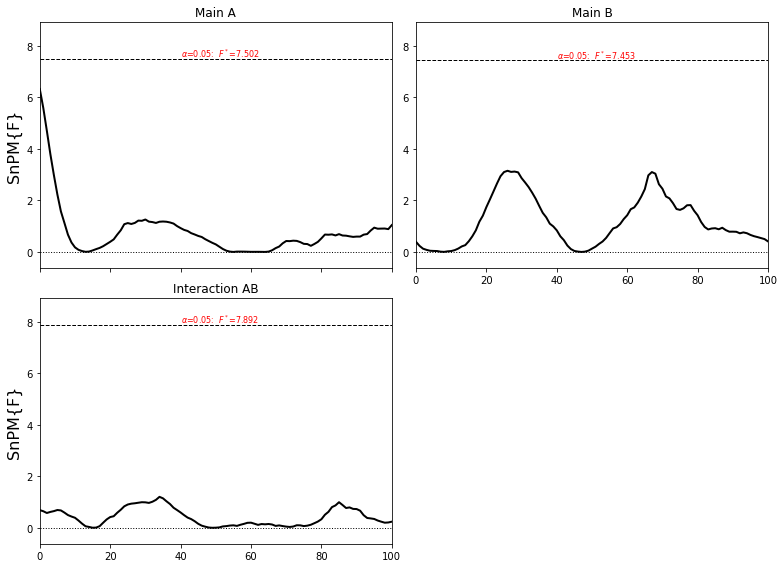

In [16]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    stats_df.to_numpy(),
    A=stats_df.index.get_level_values("expert"),
    B=stats_df.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [31]:
for i in spmi:
    print(i)

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.50194
   SPM.h0reject       :  False
   SPM.p              :  ()

SnPM{F} inference field
   SPM.effect         :  Main B
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.45320
   SPM.h0reject       :  False
   SPM.p              :  ()

SnPM{F} inference field
   SPM.effect         :  Interaction AB
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.89163
   SPM.h0reject       :  False
   SPM.p              :  ()



In [45]:
clusters = pd.DataFrame(
    {
        "effect": ["main sex", "main mass"],
        "p": [0, 0],
        "start": [0, 0],
        "end": [100, 100],
    }
)
effect = {"main sex": "expert", "main mass": "mass", "interaction sex-mass": "expert"}
describe_clusters(
    clusters, data[id_vars + [value]].rename(columns={value: "value"}).dropna(), effect
)

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main sex,0,0,100,0 - 1,0.04,0.0,no
1,main mass,0,0,100,8 - 12,0.01,0.0,no


In [38]:
base = alt.Chart(data[id_vars + [value]]).encode(
    alt.X(
        "index", title="Normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(f"mean({value})", title="box-thorax distance (% height)",)
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y(value, title=None))
men_scale = alt.Scale(scheme="set1")

In [39]:
(mu + sigma)

alt.LayerChart(...)

In [40]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale))

alt.LayerChart(...)

In [41]:
(mu + sigma).encode(alt.Color("mass:N"))

alt.LayerChart(...)

In [42]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale)).facet(column="mass")

alt.FacetChart(...)